## init

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms
# import sys
# sys.path.insert(0, '/gpfs/projects/qm_inorganics/notebook_edvin/git/autoadsorbate/')

import seaborn as sns
import pandas as pd

import numpy as np

In [3]:
from ase.build import fcc111
from ase.build import fcc211

In [4]:
from autoadsorbate.string_utils import _example_config, _show_ussage, construct_smiles, xx_get_special_symbols
from autoadsorbate.autoadsorbate import Fragment, Surface
from autoadsorbate.Surf import conformer_to_site

In [5]:
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O

In [6]:
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import plotly.express as px
from ase.build.tools import sort as sort_atoms

### read all files

In [7]:
# # dsr_traj = read('./relax_Cu111_Cu2_try2/dsr_traj_from_relaxed_slab+ads.xyz', index=':')

# aads_files = []
# for a in dsr_traj:
#     f = glob(f"./relax_Cu111_Cu2_try2/MACE_relax_*{a.info['uid']}*.xyz")
#     aads_files += f
    
# origins = ['aads' for _ in aads_files]

# ocp_files = []
# # ocp_files += glob('./relax_Cu111_Cu2_ocp/MAC*.xyz')
# # origins+=['ocp' for file in ocp_files]

# all_files = aads_files + ocp_files
# len(all_files)

## develop attach

In [ ]:
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O

In [ ]:
f = Fragment('S1S[OH+]CC[OH+]1')

In [ ]:
view(f.conformers)

## conformer_to_site

In [ ]:
import inspect
inspect.getabsfile(conformer_to_site)

In [ ]:
from ase.build import fcc211
from autoadsorbate.Surf import conformer_to_site
from autoadsorbate import Surface, ActiveSite

slab = fcc211(symbol = 'Cu', size=(6,3,3), vacuum=10)
slab = slab[[atom.index for atom in slab if atom.index not in [1,2,8, 16]]]
s=Surface(slab)

conformer = Fragment('ClCCC').conformers[0]

view(
    conformer_to_site(s.atoms, s.site_df.loc[20].to_dict(), conformer, mode='optimize', overlap_thr=0)
)

## get_populated_sites

In [ ]:
s.view_surface(mode='hedgehog')

In [ ]:
from ase.build import fcc211
from autoadsorbate.autoadsorbate import Surface, Fragment

slab = fcc211(symbol = 'Cu', size=(6,3,3), vacuum=10)
s=Surface(slab, touch_sphere_size=2.7)
s.sym_reduce()

fragments = [
    Fragment('S1S[OH+]CC(N)[OH+]1', to_initialize=20),
    Fragment('Cl[OH+]CC(=O)[OH+]', to_initialize=5)
]

out_trj = []
for  fragment in fragments:
    out_trj += s.get_populated_sites(fragment, site_index='all', sample_rotation=True, mode='heuristic',
                                     conformers_per_site_cap=5, overlap_thr=1.6, verbose=True)
    print('out_trj ', len(out_trj))

In [ ]:
view(out_trj)

## make all co2

In [ ]:
files = glob(f"./relax_Cu111_Cu2_try2/MACE_relax_*.xyz")
files.sort()

all_smiles = []
all_smiles_trj = []
for file in files:
    try:
        a=read(file)
        all_smiles += [a.info['smiles']] 
        all_smiles_trj.append(a)
    except:
        print(file)
    
len(all_smiles)

In [10]:
write('./all_smiles_trj.xyz', all_smiles_trj)

In [ ]:
print('Reading generated traj . . . ')
traj = []
for file in glob('./RELAX/relax_Cu211_get_population/generate/generated_*.xyz'):
    traj += read(file, index=':')
print(f'Done reading generated traj . . . found {len(traj)}')

## aads MACE relaxed intermediates

In [34]:
# print('Reading generated traj . . . ')
# traj = []
# for file in glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz'):
#     traj += read(file, index=':')
# print(f'Done reading generated traj . . . found {len(traj)}')

In [9]:
# all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
all_files = glob('./prep/relax/MACE*.xyz')
len(all_files)

10082

In [10]:
rdf, relaxed_traj = read_relax_dir(all_files)

In [12]:
rdf['origin'] = ['aads' for _ in all_files]

### process df

In [13]:
pwd

'/root/projects/aads'

In [14]:
from mace.calculators import mace_mp

ref_atoms = relaxed_traj[0].copy()[[atom.index for atom in relaxed_traj[0] if atom.symbol == 'Cu']]
calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
ref_atoms.set_calculator(calc)
parent_en = ref_atoms.get_potential_energy()

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/root/venvs/mace_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_21898/541118697.py:5: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)
/root/venvs/mace_env/lib/python3.12/site-packages/torch_dftd/torch_dftd3_calculator.py:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  cell: Optional[Tensor] = torch.tensor(


In [15]:
ref_dict={
    'C' : 0,
    'O' : 0,
    'H' : 0
}

# parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

xdf = compute_energy(rdf, ref_dict, parent_en)
xdf = xdf[xdf['energy']>-100]

In [16]:
xdf.pop('adsorbate_info')

0        {'site': {'coordinates': [2.9157655282254495, ...
1        {'site': {'coordinates': [2.9157655282254495, ...
2        {'site': {'coordinates': [2.9157655282254495, ...
3        {'site': {'coordinates': [2.9157655282254495, ...
4        {'site': {'coordinates': [2.9157655282254495, ...
                               ...                        
10077    {'site': {'coordinates': [2.9157655282254495, ...
10078    {'site': {'coordinates': [2.9157655282254495, ...
10079    {'site': {'coordinates': [2.9157655282254495, ...
10080    {'site': {'coordinates': [2.9157655282254495, ...
10081    {'site': {'coordinates': [2.9157655282254495, ...
Name: adsorbate_info, Length: 10082, dtype: object

In [17]:
# _xdf.head().to_dict(orient='list')

In [66]:
import chemiscope

_xdf = xdf[
        (xdf['energy']>-100)
        & (xdf['energy']< 40)
        & (xdf.bond_change == 0)
        & xdf.backbone_formula.isin(['C','C2','C2O','CO','CO2','O', 'O2'])
        # & (xdf.origin == 'aads')
        # & (xdf.H < 7)
]

if 'array_from_ocp' in _xdf.columns:
    _xdf.pop('array_from_ocp')

C_bonds_O = []
for i in _xdf.traj_index.values:
    sx = count_C_next_to_O(relaxed_traj[i])
    C_bonds_O.append(sx)
_xdf['C_bonds_O'] = C_bonds_O

backbone = []
for i in _xdf.index.values:
    f = _xdf.backbone_formula.loc[i]
    if f == 'C2O' and (_xdf.loc[i]['C_bonds_O'] == 2):
        f = 'COC'
    backbone.append(f)
_xdf['backbone'] = backbone

#set H_max for each backbone manually
map_H_max = {'C': 3, 'C2': 6, 'C2O': 6, 'CO': 4, 'CO2': 4, 'O': 2, 'O2': 2}
map_backbone = dict([(v,i) for i, v in enumerate(sorted(list(_xdf.backbone.unique())))])

#make plot float for plotting energy verus multiple in 2d
map_origin = {'aads':0, 'ocp':1}
_xdf['plot_float'] = [
    map_backbone[_xdf.backbone.values[i]] + _xdf.H.values[i]/20  + map_origin[_xdf.origin.values[i]]*0.5 for i in range(len(_xdf))
] 
_xdf['plot_float'] = _xdf['plot_float'] * 0.2
_xdf['H_max'] = [map_H_max[_xdf.backbone_formula.values[i]] for i in range(len(_xdf))]
_xdf = _xdf[_xdf['H'] <= _xdf['H_max']]

#make reference energy
_xdf['calibrate_keys'] = _xdf.backbone + '-H' + _xdf.H.astype(int).astype(str)

set_zero_dict = {}

for k, v in dict(_xdf.groupby(['backbone','H']).energy.min()).items():
    key = f'{k[0]}-H{int(k[1])}'
    set_zero_dict[key] = v

group_ref_energy = []
for k in _xdf['calibrate_keys']:
    group_ref_energy.append(set_zero_dict[k])

_xdf['group_ref_energy'] = group_ref_energy
_xdf['energy_calibrated'] = _xdf['energy'] - _xdf['group_ref_energy']

print(f'remaining values in DF: {len(_xdf)}')

/tmp/ipykernel_21898/1330508849.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O
/tmp/ipykernel_21898/1330508849.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/tmp/ipykernel_21898/1330508849.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

remaining values in DF: 5359


### chemiscope

In [67]:
# chemiscope.show(
#     frames=[relaxed_traj[i] for i in _xdf.traj_index.values],
#     properties=_xdf.to_dict(orient='list'),
#     mode='default',
# )

In [68]:
chemiscope.write_input(
    frames=[relaxed_traj[i] for i in _xdf.traj_index.values],
    properties=_xdf.to_dict(orient='list'),
    path='chemiscope_input.json'
    # mode='default',
)

/root/venvs/mace_env/lib/python3.12/site-packages/chemiscope/structures/__init__.py:93: UserWarning: the following structure properties are only defined for a subset of frames: ['C', 'H', 'O']; they will be ignored
  return _ase_list_structure_properties(frames)


### plot atoms

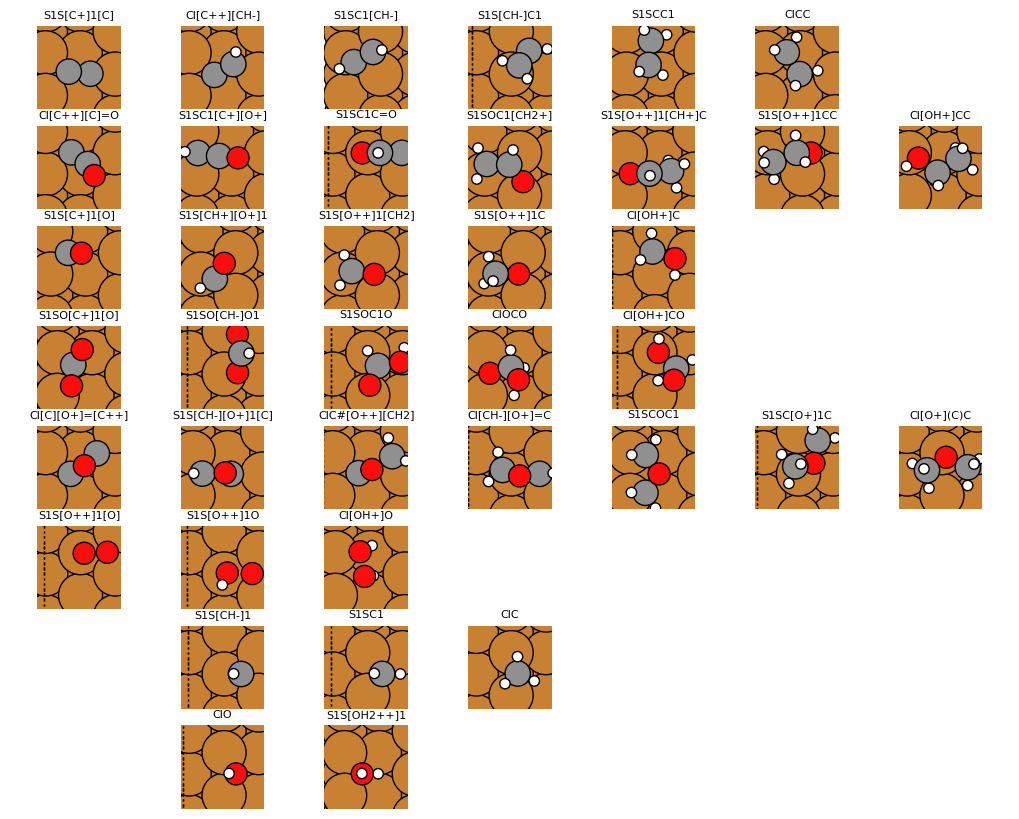

In [36]:
fig, axs = plt.subplots(
    ncols=len(_xdf.H.unique()),
    nrows=len(_xdf.backbone.unique()),
    figsize=[10,8]
)

_xdf = _xdf.sort_values(by=['H', 'backbone'])

view_atoms = []

for i, backbone in enumerate(_xdf.backbone.unique()):
    for j, H in enumerate(_xdf.H.unique()):

        ax = axs[i,j]
        
        df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
        # df_slice.sort_values(by=['energy', 'backbone', 'H'],ascending=True)
        df_slice=df_slice[df_slice.energy==df_slice.energy.min()]
        
        if len(df_slice) > 0:
            e = np.round(df_slice.iloc[0].energy,2)
            origin = df_slice.iloc[0].origin
            traj_index = df_slice.iloc[0].traj_index
            
            atoms = relaxed_traj[traj_index].copy()
            shift = - atoms[[atom.index for atom in atoms if atoms.arrays['fragments'][atom.index] == 1]].get_center_of_mass() + atoms.cell[0]*.5+ atoms.cell[1]*.5
            atoms.positions += shift
            atoms.wrap()
            
            plot_atoms(atoms, ax, rotation=('0x,0y,0z'), show_unit_cell=2)
            ax.set_title(atoms.info['adsorbate_info']['smiles'], size=8)
            
        ax.set_axis_off()
        ax.set_xlim(1, 6)
        ax.set_ylim(2, 7)
        # x = cell[0][0] + cell[1][0]
        # y = cell[0][1] + cell[1][1]
        # ax.set_xlim(x+2, x+9)
        # ax.set_ylim(y-3, y+3)
        
        view_atoms.append(atoms)

# fig.set_layout_engine(layout='tight')
plt.tight_layout(pad=0.01, w_pad=0.4, h_pad=0.01)

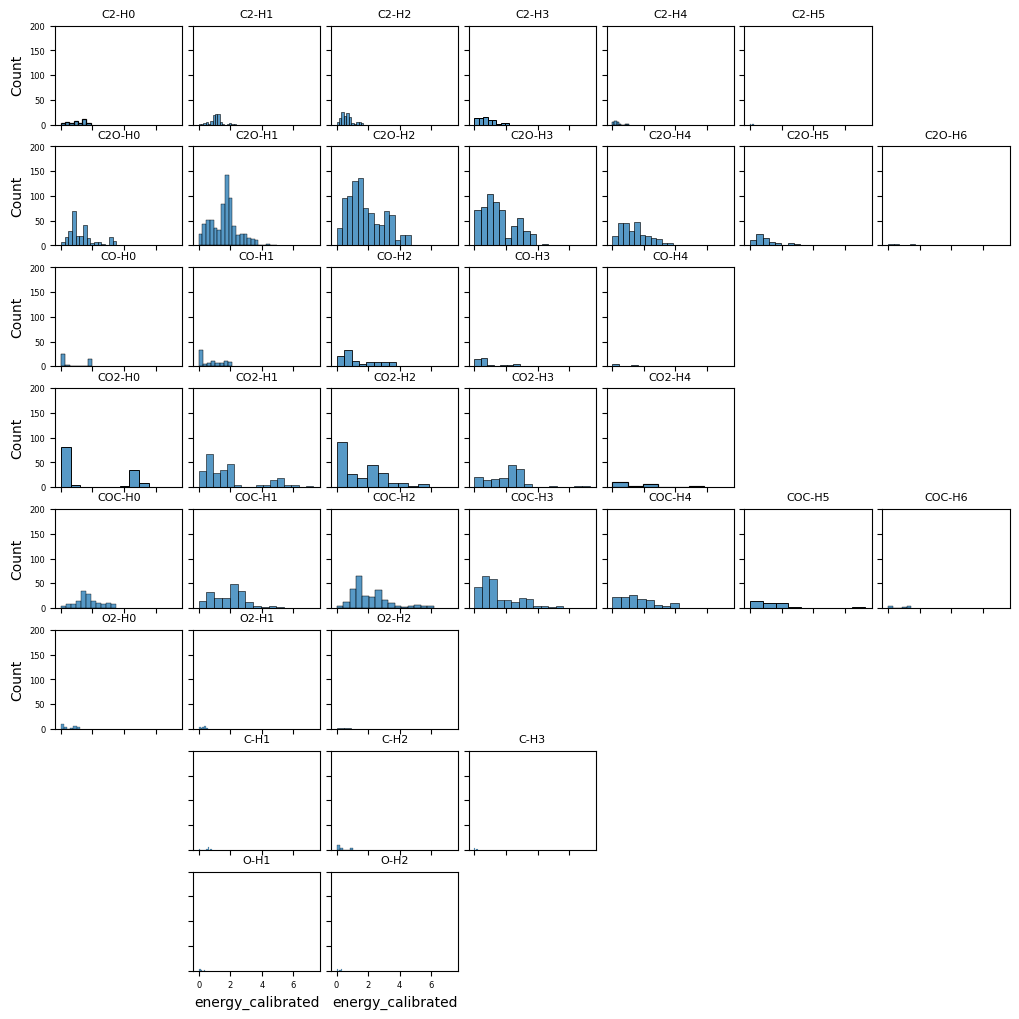

In [83]:
fig, axs = plt.subplots(
    ncols=len(_xdf.H.unique()),
    nrows=len(_xdf.backbone.unique()),
    figsize=[10,10],
    sharex=True,
    sharey=True,
)

_xdf = _xdf.sort_values(by=['H', 'backbone'])

view_atoms = []

for i, backbone in enumerate(_xdf.backbone.unique()):
    for j, H in enumerate(_xdf.H.unique()):

        ax = axs[i,j]
        
        df_slice = _xdf[_xdf.H.isin([H]) & _xdf.backbone.isin([backbone])]
        # df_slice.sort_values(by=['energy', 'backbone', 'H'],ascending=True)
        # df_slice=df_slice[df_slice.energy==df_slice.energy.min()]
        
        if len(df_slice) > 0:
            sns.histplot(df_slice, x='energy_calibrated', ax=ax)
            ax.set_title(df_slice.calibrate_keys.values[0], size=8)
            ax.set_ylim(0, 200)
            ax.tick_params(axis='x', labelsize=6)
            ax.tick_params(axis='y', labelsize=6)

        else:
            ax.set_axis_off()
        # ax.set_xlim(1, 6)
        
        # x = cell[0][0] + cell[1][0]
        # y = cell[0][1] + cell[1][1]
        # ax.set_xlim(x+2, x+9)
        # ax.set_ylim(y-3, y+3)
        
        view_atoms.append(atoms)

# fig.set_layout_engine(layout='tight')
plt.tight_layout(pad=0.01, w_pad=0.4, h_pad=0.01)

In [ ]:
view(traj)

In [49]:
rdf.columns

Index(['adsorbate_info', 'uid', 'mlff_energy', 'bond_change',
       'backbone_formula', 'snap_pos_compare', 'C', 'O', 'H', 'traj_index',
       'origin', 'C_en', 'H_en', 'O_en', 'parent_en', 'energy'],
      dtype='object')

In [9]:
from autoadsorbate.Surf import get_shrinkwrap_grid

In [ ]:
grd = get_shrinkwrap_grid(slab, .5)
grd.positions -= [0,0,15.]
grd.positions *= [1,1,3]
view(grd)

In [24]:
write('/gpfs/users/home/fakoed/Desktop/aa.xyz', grd)